This notebook takes the preprocessed dataset; creates some artificial effects of the predictors on the outcomes, and then saves this into a new file. The reason for doing this is to test whether the pipeline works.

# Get data for mixing

In [184]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from dev_interaction_util import *
from DevCvAnalysis import DevCvAnalysis
import matplotlib.pyplot as plt

config = load_config("config.yml") 

dropbox_data_dir = config['dropbox_data_dir']


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
%load_ext autoreload
%autoreload 2

from InterventionCVManager import *

dropbox_data_dir = config['dropbox_data_dir']

icvm = InterventionCVManager(dropbox_data_dir)
#icvm.mode = 'full_pipeline_test'
#icvm.mode = 'fast_pipeline_test'
icvm.mode = 'full_analysis'

#dev_cv_analysis = icvm.get_prepopulated_dev_cv_analysis(set_as_random=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [186]:
%load_ext autoreload
%autoreload 2
dev_cv_analysis = icvm.get_prepopulated_dev_cv_analysis(set_as_random=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
pre merge: 275
post merge: 270
participants in pre merge but not post merge: {'DEV002', 'DEV007', 'DEV280', 'DEV022', 'DEV032'}
Index(['Unnamed: 0', 'subject_id', 'wave', 'spm_l2_path', 'condition',
       'beta_name', 'mask_label', 'roi_activity', 'run', 'task'],
      dtype='object')
Index(['Unnamed: 0', 'subject_id', 'wave', 'spm_l2_path', 'condition',
       'beta_name', 'mask_label', 'roi_activity', 'run', 'task'],
      dtype='object')
Index(['Unnamed: 0', 'subject_id', 'wave', 'spm_l2_path', 'condition',
       'beta_name', 'mask_label', 'roi_activity', 'task', 'run'],
      dtype='object')
run_real_analysis is True, so we're not randomizing the outcomes. 
(243, 33)
(243, 33)


/Users/benjaminsmith/Google Drive/oregon/code/DEV_scripts/analyses/intervention_moderation/dev_interaction_util.py:1003: FutureWarning: The default value of regex will change from True to False in a future version.
  ms_groups['intervention_group'] = ms_groups['group_raw'].str.replace(r"\(.*\)","")


In [187]:
data_by_ppt_raw = pd.read_csv(dev_cv_analysis.data_by_ppt_path)

In [188]:
data_codebook = pd.read_csv(dev_cv_analysis.data_codebook_path,skiprows=1)

In [189]:
data_by_wave = pd.read_csv(dev_cv_analysis.data_by_wave_ppt_path)

We will be saving a new 'data by wave' file that mixes in some data from the predictors. Data by wave is not directly what we predict--it's raw values before difference scores are calculated. Because I want to save the data in the actual format used by DevCvAnalysis, we're going to mix predictors into the raw values. These will then be included in the difference scores later on.

To do this we need to get data_by_ppt with rows exactly corresponding to data_by_wave. This will help us do the mixing.

In [190]:
predictors_raw_by_ppt_wave = pd.merge(
    data_by_wave.loc[:,['SID']],
    data_by_ppt_raw,on='SID',how='left')

In [191]:
print(data_by_ppt_raw.shape)
print(data_by_wave.shape)
print(predictors_raw_by_ppt_wave.shape)

(275, 172)
(1813, 128)
(1813, 172)


# Create a artificial effects mixer

Let's start by creating a real simple, dream effect. Let's say there are 5 specific predictors that meaningfully predict change in the outcomes, with, say, r=0.2.

In [192]:

import numpy as np

def create_mixed_vector_no_nas(x, y, r):
    x_na = np.isnan(x)
    y_na = np.isnan(y)
    na_mask = np.logical_or(x_na, y_na)
    y_mixed = create_mixed_vector(x[~na_mask], y[~na_mask], r)
    y_out = y.copy()
    y_out[~na_mask] = y_mixed
    return y_out
    
def create_mixed_vector(x, y, r):

    
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    x_norm = x- x_mean
    y_norm = y- y_mean
    
    # Scale by standard deviations
    x_std = np.std(x)
    y_std = np.std(y)
    x_norm /= x_std
    y_norm /= y_std
    
    proj = np.dot(x_norm, y_norm) / np.dot(x_norm, x_norm)
    y_orth = y_norm - proj * x_norm
    #y_orth = y - proj * x_norm
    # Modify the correlation coefficient of y with x
    # current_correlation = np.corrcoef(x, y)[0, 1]
    # y -= current_correlation * x

    
    # Scale and shift y to match the desired correlation coefficient
    #y_norm = (1- r ) * y_orth + r * x_norm
    y_norm = y_orth + r * x_norm
    y_norm *= np.sqrt(y_std * x_std)
    y_norm += y_mean
    
    return y_norm

In [193]:

# import numpy as np

# def create_mixed_vector_no_nas(x, y, r):
#     x_na = np.isnan(x)
#     y_na = np.isnan(y)
#     na_mask = np.logical_or(x_na, y_na)
#     y_mixed = create_mixed_vector(x[~na_mask], y[~na_mask], r)
#     y_out = y.copy()
#     y_out[~na_mask] = y_mixed
#     return y_out

# def create_mixed_vector(x, y, r):
    
#     proj = np.dot(x, y) / np.dot(x, x)
#     y_orth = y - proj * x
#     #in this version we'll normalize AFTER orthogonalizing

#     x_mean = np.mean(x)
#     y_mean = np.mean(y)
#     y_orth_mean = np.mean(y_orth)
#     x_norm = x- x_mean
#     y_norm = y- y_mean
#     y_orth_norm = y_orth - y_orth_mean
    
#     # Scale by standard deviations
#     x_std = np.std(x)
#     y_std = np.std(y_orth)
#     y_orth_std = np.std(y_orth)
#     x_norm /= x_std
#     y_norm /= y_std
#     y_orth_norm /= y_orth_std
    

    
#     # Scale and shift y to match the desired correlation coefficient
#     #y_norm = (1- r ) * y_norm + r * x_norm
#     y_out = y_orth_norm + r * x_norm
#     #y_norm *= np.sqrt(y_std * x_std)
#     y_out *= y_std
#     y_out += y_mean
    
#     return y_out

# Test the mixer

In [194]:
#import pearson's correlation test
from scipy.stats import pearsonr





# Create a new vector y2 with Pearson's correlation of 0.3 with vector x
#it doesn't work exactly but it's close.
#has fairly low variance because we orthogonalize the y before we mix the correlated vector


#calculate pearson's correlation
corr_mean = [0]*1000
for i in range(1000):
    # Generate random normally distributed vectors x and y
    x = np.random.normal(size=300)
    y = np.random.normal(size=300)
    y2 = create_mixed_vector_no_nas(x, y, 0.3)
    corr, _ = pearsonr(x, y2)
    corr_mean[i] = corr
    #print(corr)

print(np.mean(corr_mean))
print(np.std(corr_mean))

0.2877921552678985
0.0006400041868706086


# Select some variables to mix

In [195]:
# select 5 random predictors
#set seed
np.random.seed(1158)
#select 5 random predictors
#to avoid going into the ROI predictors which will be complicated we'll just look for predictors of Category self-report
predictors_to_mix = np.random.choice(data_codebook[data_codebook.Aim3PredictorsFinal & (data_codebook.Category=='self-report')]['VarName'], 5, replace=False)
predictors_to_mix

#now mix them in to specified outcomes


array(['Restraint_aggregate', 'PCS', 'BFI_openness', 'TESQ_E_sum',
       'BFI_agreeableness'], dtype=object)

In [196]:
all_outcomes = data_codebook[data_codebook.IsSelectedLongitudinalOutcomeMeasure]['VarName']
print(all_outcomes)

143                                      bf
144    NUTRIENT_RICH_FOODS_INDEX_2wkAverage
146         ANTINUTRIENT_DENSITY_2wkAverage
147                           total_calorie
Name: VarName, dtype: object


Let's mix in for the two subj evaluated items but not for smoking_feelings.

# Do the mixing

We want the second sessionw with bf and calorie data, which is session 2.

1    284
2    254
3    233
4    203
5    159
Name: session_id, dtype: int64
1    256
2    227
3    217
4    211
5    169
Name: session_id, dtype: int64
bf
bf Restraint_aggregate
                     Restraint_aggregate        bf
Restraint_aggregate             1.000000  0.046393
bf                              0.046393  1.000000
                     Restraint_aggregate        bf
Restraint_aggregate             1.000000  0.287632
bf                              0.287632  1.000000
bf PCS
          PCS        bf
PCS  1.000000 -0.139267
bf  -0.139267  1.000000
          PCS        bf
PCS  1.000000  0.289939
bf   0.289939  1.000000
bf BFI_openness
              BFI_openness        bf
BFI_openness      1.000000  0.114488
bf                0.114488  1.000000
              BFI_openness        bf
BFI_openness      1.000000  0.289091
bf                0.289091  1.000000
bf TESQ_E_sum
            TESQ_E_sum        bf
TESQ_E_sum    1.000000  0.285923
bf            0.285923  1.000000
            TE

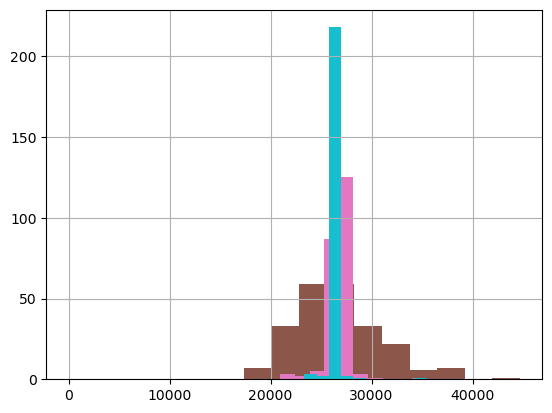

In [197]:
artificial_data = data_by_wave.copy()
print(artificial_data.loc[np.isnan(artificial_data.bf)==False,:].session_id.value_counts())
print(artificial_data.loc[np.isnan(artificial_data.total_calorie)==False,:].session_id.value_counts())

session_to_modify = 2
rows_to_modify = artificial_data.session_id==session_to_modify

outcomes_to_mix = ['bf','total_calorie']
for outcome_to_mix in outcomes_to_mix:
    print(outcome_to_mix)
    # plt.figure()
    # artificial_data.loc[rows_to_modify,outcome_to_mix].hist()
    # #show the histogram
    # plt.show()

    for predictor_to_mix in predictors_to_mix:
        print(outcome_to_mix, predictor_to_mix)
        print(pd.concat([predictors_raw_by_ppt_wave.loc[rows_to_modify,predictor_to_mix],artificial_data.loc[rows_to_modify,outcome_to_mix]],axis=1).corr())

        # #do a histogram
        # plt.figure()
        # predictors_raw_by_ppt_wave.loc[rows_to_modify,predictor_to_mix].hist()
        # #show the histogram
        # plt.show()



        artificial_data.loc[rows_to_modify,outcome_to_mix].hist()

        mixed_data = create_mixed_vector_no_nas(
            predictors_raw_by_ppt_wave.loc[rows_to_modify,predictor_to_mix],
            artificial_data.loc[rows_to_modify,outcome_to_mix],0.3)
        #now, the thing is; we only want to apply the mixed values to a particular wave
        artificial_data.loc[rows_to_modify,outcome_to_mix] = mixed_data
        print(pd.concat([predictors_raw_by_ppt_wave.loc[rows_to_modify,predictor_to_mix],artificial_data.loc[rows_to_modify,outcome_to_mix]],axis=1).corr())
        
                        

In [198]:
artificial_data.loc[rows_to_modify,outcome_to_mix]

3                NaN
11               NaN
18               NaN
29               NaN
33               NaN
            ...     
1781    26746.476508
1787    26747.987681
1793    26735.300472
1799    26746.404501
1805    26729.774301
Name: total_calorie, Length: 256, dtype: float64

In [199]:
rows_to_modify.value_counts()

False    1557
True      256
Name: session_id, dtype: int64

# Verify difference scores correlate with predictors

### with raw artificial output

In [200]:
artificial_data_s2_modified = artificial_data.loc[(artificial_data.session_id==2),['SID']+outcomes_to_mix]
all_data = dev_cv_analysis.get_full_dataset().merge(artificial_data_s2_modified,on='SID',how='inner')
all_data.shape

(243, 214)

In [201]:
all_data[predictors_to_mix.tolist()+outcomes_to_mix].corr()

,Restraint_aggregate,PCS,BFI_openness,TESQ_E_sum,BFI_agreeableness,bf,total_calorie
Restraint_aggregate,1.000000,0.001655,0.049190,0.385656,-0.037227,0.258545,0.128296
PCS,0.001655,1.000000,0.204315,0.237916,0.147926,0.334112,0.144213
BFI_openness,0.049190,0.204315,1.000000,0.125879,0.175945,0.312763,0.318026
TESQ_E_sum,0.385656,0.237916,0.125879,1.000000,0.051700,0.295799,0.292661
BFI_agreeableness,-0.037227,0.147926,0.175945,0.051700,1.000000,0.289194,0.289381
bf,0.258545,0.334112,0.312763,0.295799,0.289194,1.000000,0.037981
total_calorie,0.128296,0.144213,0.318026,0.292661,0.289381,0.037981,1.000000


### with diff scores

First we should run the outcome script in order to view how it works with the difference scores..

In [202]:
data_codebook = pd.read_csv(dev_cv_analysis.data_codebook_path,skiprows=1)
outcome_data = get_outcome_diff_scores_from_longitudinal_dfs(data_codebook,artificial_data)

In [203]:
preprocessed_full_predictor_set = dev_cv_analysis.get_full_dataset()
all_data = pd.merge(preprocessed_full_predictor_set,outcome_data,on='SID',how='inner')

In [204]:
predictors_to_mix

array(['Restraint_aggregate', 'PCS', 'BFI_openness', 'TESQ_E_sum',
       'BFI_agreeableness'], dtype=object)

In [205]:
all_data[predictors_to_mix.tolist()+outcomes_to_mix].corr()

,Restraint_aggregate,PCS,BFI_openness,TESQ_E_sum,BFI_agreeableness,bf,total_calorie
Restraint_aggregate,1.000000,0.001655,0.049190,0.385656,-0.037227,0.283642,-0.137862
PCS,0.001655,1.000000,0.204315,0.237916,0.147926,0.709209,0.036972
BFI_openness,0.049190,0.204315,1.000000,0.125879,0.175945,0.396669,-0.120324
TESQ_E_sum,0.385656,0.237916,0.125879,1.000000,0.051700,0.267487,-0.026025
BFI_agreeableness,-0.037227,0.147926,0.175945,0.051700,1.000000,0.368428,-0.033023
bf,0.283642,0.709209,0.396669,0.267487,0.368428,1.000000,0.034615
total_calorie,-0.137862,0.036972,-0.120324,-0.026025,-0.033023,0.034615,1.000000


# Save

In [206]:
artificial_data.to_csv(dropbox_data_dir + 'data_by_wave_ppt_artificial.csv')

I haven't really got the intedned correlations, because my function wasn't intended to add these cumulatively.

Still, it's now at the point that the cross-validation should detect some effects. If it doesn't, something's wrong with the cross-validation, or it is radically under-powered.